# Here we build a BBB classifier using a publicly available dataset

taken from: https://github.com/theochem/B3DB

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops, Draw, Descriptors, rdDepictor, PandasTools, rdMolDescriptors as rdmd;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
import sys
print(f"I am python version {sys.version}")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


I am RDKit version: 2023.09.5
I am python version 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [2]:
data = pd.read_csv("../data/B3DB_classification_original.tsv", sep='\t')
print(f"The dataset contains {data.shape[0]} endpoints on BBB")
data.head(3)

The dataset contains 7807 endpoints on BBB


,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO.            7807 non-null   int64  
 1   compound_name  6698 non-null   object 
 2   IUPAC_name     6170 non-null   object 
 3   SMILES         7807 non-null   object 
 4   CID            6170 non-null   float64
 5   logBB          1058 non-null   float64
 6   BBB+/BBB-      7807 non-null   object 
 7   Inchi          7807 non-null   object 
 8   threshold      3621 non-null   float64
 9   reference      7807 non-null   object 
 10  group          7807 non-null   object 
 11  comments       18 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 732.0+ KB


There are 7807 molecules and we can see that the class labels BBB+/BBB- are present for all of them. Lets check their distribution:

In [4]:
data['BBB+/BBB-'].value_counts()

BBB+/BBB-
BBB+    4956
BBB-    2851
Name: count, dtype: int64

The dataset is skewed towards BBB permeable compounds (BBB+). Hence, we might need to do a stratified k-fold split later on while training and testing the predictive model.

For now, let's keep the required columns:

## Clean the dataset

In [5]:
data = data[['compound_name','SMILES', 'BBB+/BBB-', 'Inchi']]

### Remove problematics smiles:

In [6]:
import sys
sys.path.insert(0, '/Users/ganeshshahane/Work/useful_cheminformatics/')

In [7]:
# remove smiles with invalid syntax:
from utils_pack import remove_faulty_smiles, clean_sanitize_dataframe

data = remove_faulty_smiles.remove(data, 'SMILES')

There are 0 invalid smiles in the dataset


In [8]:
# remove smiles with mutiple fragments and transition metals

df = clean_sanitize_dataframe.filter_smiles(data, 'SMILES')
print(f"{data.shape[0] - df.shape[0]} molecules have been removed by because of transition metals or salts")

print(f"The size of new dataset is {df.shape[0]}")

10 molecules have been removed by because of transition metals or salts
The size of new dataset is 7797


In [9]:
# Check which SMILES have been removed:

differences = pd.concat([data, df]).drop_duplicates(subset='SMILES', keep=False)

differences.SMILES.to_list()

['CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O',
 'CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC1C[C@@H](C/C=C(\\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](OC4C[C@H](OC)[C@@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2.CO[C@H]1CC(O[C@H]2[C@H](C)O[C@@H](O[C@@H]3/C(C)=C/C[C@@H]4CC(C[C@]5(CC[C@H](C)[C@@H](C(C)C)O5)O4)OC(=O)[C@@H]4C=C(C)[C@@H](O)[C@H]5OC/C(=C\\C=C\\[C@@H]3C)[C@@]45O)C[C@@H]2OC)O[C@@H](C)[C@@H]1O',
 'CNO.Cc1oc(C(C)(C)N(C(C)(C)N)C(C)(C)N)c(C)c1C',
 'ClCC1CO1.NCCNCCNCCNCCN',
 'C=C[C@](C)(O)C(C)(C)C.COC12CC3(C1)[C@H]1Cc4ccc(O)c5c4[C@@]3(CCN1CC1CC1)[C@H]2O5',
 'CCNCNCCSCc1ncccc1Br.N#CN',
 'CNCNCCSCc1nc[nH]c1C.N#CN',
 'CNCNc1cccc(-c2csc(N)n2)c1.N#CN.NCN',
 'NCN.Nc1cccc(-c2csc(N)n2)c1',
 'NCN.Nc1nc(-c2ccccc2)cs1']

In [10]:
# Check the distribtution of labels again:

df['BBB+/BBB-'].value_counts()

BBB+/BBB-
BBB+    4953
BBB-    2844
Name: count, dtype: int64

In [11]:
# Visualise some of the molecules:

df['mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

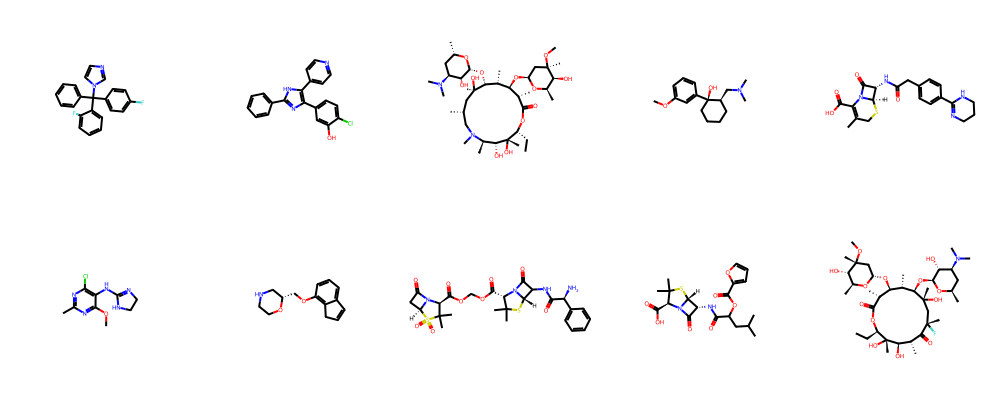

In [12]:
Draw.MolsToGridImage(df.mol.sample(10), molsPerRow=5)

In [27]:
#df.to_csv("../data/B3DB_classification_cleaned.csv")

## Generate features

In [13]:
# We use the molfeat package to generate descriptors

from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer

# Instantiate a Fingerprint calculator
calc = FPCalculator("ecfp")

# Instantiate a molecule transfomer from molfeat. This object takes a list of SMILES as input and returns descriptors.
trans = MoleculeTransformer(calc)

In [14]:
import datamol as dm

with dm.without_rdkit_log():
    
    df['fp'] = trans.transform(df.SMILES.values)

In [15]:
df.head(2)

,compound_name,SMILES,BBB+/BBB-,Inchi,mol,fp
0,sulphasalazine,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,<rdkit.Chem.rdchem.Mol object at 0x17a24b060>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,moxalactam,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,<rdkit.Chem.rdchem.Mol object at 0x17a24b0d0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
# We re-label BBB+ as 1 and BBB- as 0

df['BBB+/BBB-'] = df['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
df['BBB+/BBB-'].value_counts()

BBB+/BBB-
1    4953
0    2844
Name: count, dtype: int64

## Train-Test Split

In [17]:
# Split the data into training and test sets

from sklearn.model_selection import train_test_split

X = pd.DataFrame(df['fp'].tolist()) # put features in a dataframe called X
y = df['BBB+/BBB-'] # put features in series y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=7)

The ```stratify``` parameter ensures that the proportion of each class in the original dataset is preserved in both the training and test sets.

Setting ```random_state``` to a particular number ensures reproducibility.

In [18]:
print(y_test.value_counts())
print(y_train.value_counts())

BBB+/BBB-
1    495
0    285
Name: count, dtype: int64
BBB+/BBB-
1    4458
0    2559
Name: count, dtype: int64


## Build Model:

Here, we use the Random Forest Classifier as it is an ensemble method. How does being an ensemble method help? The RF classfier is extension of bagging that further randomizes feature selection during tree construction.

Random Forests are robust against overfitting and handle class imbalance well.

They provide accurate predictions by combining multiple decision trees.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Initialize a Random Forest Classifier (you can choose other ensemble classifiers)
clf = RandomForestClassifier(random_state=70)

# Train the model on the imbalanced data
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=70)

## Evaluate the model

In [20]:
# Calculate accuracy by comparing the number of predictions made VS actual labels
accuracy = clf.score(X_test, y_test)
print(f"Classifier Accuracy: {accuracy:.2f}\n")

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Produce the classification report:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classifier Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80       285
           1       0.86      0.95      0.90       495

    accuracy                           0.87       780
   macro avg       0.88      0.84      0.85       780
weighted avg       0.87      0.87      0.87       780



In [21]:
# Calculate AUC:

y_prob = clf.predict_proba(X_test)[:, 1]  # Predicted probabilities for positive class
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}\n")

# Compute confusion matrix:

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

AUC: 0.9610

Confusion Matrix:
[[207  78]
 [ 24 471]]


## Save and reuse the model

In [22]:
import joblib

joblib.dump(clf, '../saved_models/BBB_classifier.model')

['../saved_models/BBB_classifier.model']

#### On a future date:

In [23]:
# Load the saved model:

load_model = joblib.load('../saved_models/BBB_classifier.model')

In [24]:
# Predict the BBB permeability of LSD

load_model.predict(pd.DataFrame(trans.transform('CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C')))

array([1])

In [25]:
# For multiple molecules (morphine and paxlovid respectively):

mol_list = ['CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O', 'CC1(C2C1C(N(C2)C(=O)C(C(C)(C)C)NC(=O)C(F)(F)F)C(=O)NC(CC3CCNC3=O)C#N)C']

load_model.predict(pd.DataFrame(trans.transform(mol_list)))

array([1, 0])